# Simulated annealing on spin glass problem

                                                                                                 Joana Fraxanet

In this jupyter notebook you can fins the implementation of the algorithm simulated annealing to find the ground state of an 2D Edwards-Anderson spin glass model, which has the following Hamiltonian:

$$H = -\sum_{<ij>}J_{ij}s_is_j,$$

where the couplings $J_{ij}$ are random variables drawn from a Gaussian distribution and we consider only nearest neighbour interactions.
The algorithm can also be implemented for other spin glass problems with different connectivity and dimensionality.


In [20]:
import numpy as np
import random
import matplotlib.pyplot as plt
import copy
import timeit

After importing the necessary packages we need to define the configuration of the problem. Let's start by defining the lattice. This will be useful to plot the spins. Note that the lattice has periodic boundary conditions.

In [21]:
def Lattice(N):
    '''Square 2D lattice within sqrtN'''
    Position = np.zeros((N,2))
    SqrtN = np.sqrt(N) 
    for i in range(N):
        Position[i][0] = (i%SqrtN)
        Position[i][1] = (i//SqrtN)  
    SpinX = Position[:,0]
    SpinY = Position[:,1]
    return SpinX, SpinY

side = 10
N = side*side #TOTAL NUMBER OF SPINS
SpinX,SpinY = Lattice(N)

Now, let us define the random couplings between nearest neighbours. 
In this case, we will write them in a NxN matrix, but there are more efficient ways to do it. For example, we could save two couplings for each spin, the one to the left and down from it. 
Here instead we have a symmetric matrix with a lot of entries being zero, but it helps making the program more intuitive.

In [22]:
def NN_Random_couplings(N, side, SpinX, SpinY):
    '''Computes the symmetric matrix with all random couplings for nearest neighbours (PERIODIC BOUNDARY CONDITIONS)'''
    Matrix = np.zeros((N,N))
    for i in range(N):
        for j in range(i+1,N):
            dist_vector = np.array([SpinX[i]-SpinX[j],SpinY[i]-SpinY[j]])
            dist_vector_PBC = (dist_vector + side/2)%side-side/2
            if np.linalg.norm(dist_vector_PBC) == 1:
                Matrix[i][j] = np.random.normal(0,1) #from N(0,1)
                Matrix[j][i] = Matrix[i][j] #symmetric
    return Matrix  

Matrix = NN_Random_couplings(N,side,SpinX,SpinY)
print(Matrix)
#np.save('Matrix.npy', Matrix)

[[ 0.          2.58195329  0.         ...  0.          0.
   0.        ]
 [ 2.58195329  0.          1.37357651 ...  0.          0.
   0.        ]
 [ 0.          1.37357651  0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.         -0.30341417
   0.        ]
 [ 0.          0.          0.         ... -0.30341417  0.
  -0.44880005]
 [ 0.          0.          0.         ...  0.         -0.44880005
   0.        ]]


We could also import the couplings from a file to be sure we are working on the same problem all the time:

In [23]:
Matrix = np.load('Matrix10.npy')
print(Matrix)

[[ 0.          0.3764402   0.         ...  0.          0.
   0.        ]
 [ 0.3764402   0.         -1.89813204 ...  0.          0.
   0.        ]
 [ 0.         -1.89813204  0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.         -1.79272444
   0.        ]
 [ 0.          0.          0.         ... -1.79272444  0.
  -0.70226097]
 [ 0.          0.          0.         ...  0.         -0.70226097
   0.        ]]


Let us define the parameters that we are going to need for the simulated annealing process.
We need to define:
- Starting Temperature
- Stopping criteria: number of temperature steps, final temperature or stabilizing criteria.. (We will use number of steps Nt)
- Equilibration steps at each given temperature. (Ne)
- Cycles we are going to perform. At each cycle we repeat the whole SA procedure, but starting from a lower temperature.
- Cooling schedule. In this case we are choosing exponential (multiply the temperature at each step by the CoolingFactor). It could also be linear or chose other more complex options.

In [24]:
StartT = 10
CoolingFactor = 0.95 
Nt = 500 
Ne = 10 
Cycles = 10 

Now let's define the core function of the problem, which will perform a Metropolis sweep over the lattice (this means flipping N spins). The sweep is performed in sequential order, but we could consider N random spins and it should also work. 

First, we will need to define a function that computes the new energy by JUST considering the difference that we obtain from flipping one spin. Since we consider nearest neighbours, computing the whole energy again would be not efficient. Instead, we only have to change the sign of the four interactions that correspond to this one spin.

This function can induce some error when we are doing a high number of iterations, and that is why we will do the whole calculation of the energy once in a while.

In [25]:
def Swap(State, Energy, Matrix, i):
    '''Computes the new energy obtained by flipping spin i'''
    NewEnergy = copy.deepcopy(Energy)
    State = np.array(State, float)
    for j in range(N):
        NewEnergy += float(4)*Matrix[i][j]*State[i]*State[j]
    return NewEnergy

The metropolis algorithm is based in the following idea. At a given temperature T, we will ALWAYS accept the moves that lower the energy. On the other hand, the moves that increase T will be accepted depending on a probability that is based on the Boltzmann distribution. Here we have to use random numbers to decide whether we are accepting the perturbation or not.

In [26]:
def Metropolis_sweep(State, Energy, BestEnergy, BestState, Matrix, T, N):
    '''Performs a N steps in the Metropolis algorithm and decides whether 
    to accept the moves or not in a given T'''    
    for i in range(N):
        spin = i
        NewEnergy = Swap(State, Energy, Matrix, spin)
        Dif = NewEnergy - Energy
        if Dif < 0: 
            State[spin] = -State[spin]
            Energy = NewEnergy
            if Energy < BestEnergy:
                BestState = copy.deepcopy(State)
                BestEnergy = Energy 
        else:
            Prob = np.exp(-Dif/T)
            dummy = random.random()
            if dummy < Prob:
                State[spin] = -State[spin]
                Energy = NewEnergy  
    return State, Energy, BestEnergy, BestState

We will also need a function that, given a configuration of spins, finds the energy of the configuration (with the Hamiltonian that was previously given for EA spin glass). Here we could add a factor 1/2N.

In [27]:
def Hamiltonian_one(Spins, Matrix, N):
    '''Computes the cost energy of a given state'''
    Energy = 0
    Spins = np.array(Spins, float)
    for i in range(N):
        for j in range(N):
            Energy += -Matrix[i][j]*Spins[i]*Spins[j]
    return Energy

Now let us define the starting random configuration, that we will perturb to obtain the ground state. We could also define a specific initial configuration, but in the case of the Spin Glass we have no information about the problem.

In [28]:
State = np.sign(np.random.rand(N)*2-1)
#np.save('State.npy', State)

We can plot the initial state to see how it looks like.

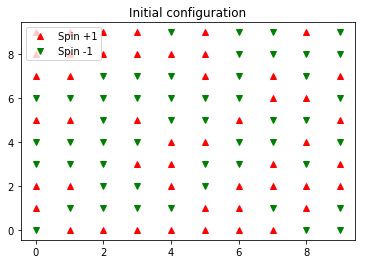

In [29]:
def PlotState(title, State, SpinX, SpinY):
    '''Plots the spin state'''
    plt.figure()
    plt.title(title)
    plt.plot(SpinX[State>0],SpinY[State>0],color='red',marker='^',linestyle='None',label='Spin +1')
    plt.plot(SpinX[State<0],SpinY[State<0],color='green',marker='v',linestyle='None',label='Spin -1')
    plt.legend()

PlotState('Initial configuration', State, SpinX, SpinY)  

It's time to start with the process of minimizing the energy. Note that we will save the best energy (and the best state corresponding to it) througout the process and that will be our result.

In [30]:
T = StartT
Energy = Hamiltonian_one(State,Matrix,N)
BestEnergy = Energy
BestState = copy.deepcopy(State) #Important to use this function to copy, otherwise we are just referring to the same element!

#Save data to plot it:
FinalEnergies = []
EnergyEvolution = []

In [31]:
for cycle in range(Cycles):
    start_cycle = timeit.default_timer() #Compute the time that it takes
    
    StepsT = 0
    print('\nSTART SIMULATED ANNEALING CYCLE ', cycle+1)
    print('Starting Temperature:', T)
    while StepsT <= Nt:
        for i in range(Ne):
            State,Energy,BestEnergy,BestState = Metropolis_sweep(State,Energy,BestEnergy,BestState,Matrix,T,N)
            EnergyEvolution = np.append(EnergyEvolution,Energy)
        T = T*CoolingFactor
        StepsT += 1
    print('Final Temperature: ', T)

    State = copy.deepcopy(BestState)
    Energy = BestEnergy = Hamiltonian_one(BestState,Matrix,N) #To make sure we did not accumulate error, we recalculate the energy at the state chosen.
    FinalEnergies = np.append(FinalEnergies, Energy)
    
    end_cycle = timeit.default_timer()
    print('MINIMUM REACHED: ', Energy)
    print('TIME: ', end_cycle-start_cycle) 
    T = StartT*CoolingFactor**(cycle+1) #Lower the temperature at the start of each new cycle


START SIMULATED ANNEALING CYCLE  1
Starting Temperature: 10
Final Temperature:  6.910766983367094e-11
MINIMUM REACHED:  -260.29787326364317
TIME:  32.19521143499878

START SIMULATED ANNEALING CYCLE  2
Starting Temperature: 9.5
Final Temperature:  6.56522863419874e-11
MINIMUM REACHED:  -260.29787326364317
TIME:  31.432829436991597

START SIMULATED ANNEALING CYCLE  3
Starting Temperature: 9.025
Final Temperature:  6.236967202488802e-11
MINIMUM REACHED:  -260.8489363922519
TIME:  31.79707967399736

START SIMULATED ANNEALING CYCLE  4
Starting Temperature: 8.573749999999999
Final Temperature:  5.925118842364362e-11
MINIMUM REACHED:  -260.8489363922519
TIME:  32.60668516199803

START SIMULATED ANNEALING CYCLE  5
Starting Temperature: 8.145062499999998
Final Temperature:  5.6288629002461435e-11
MINIMUM REACHED:  -260.8489363922519
TIME:  32.77563742198981

START SIMULATED ANNEALING CYCLE  6
Starting Temperature: 7.737809374999998
Final Temperature:  5.347419755233836e-11
MINIMUM REACHED:  -2

Let us plot the final energy obtained at the end of each cycle. If it is constant, the ground state was obtained already on the first cycle (or we are in a local minima that is really difficult to overcome and therefore not reaching the gound state).

[-260.29787326 -260.29787326 -260.84893639 -260.84893639 -260.84893639
 -260.84893639 -260.84893639 -260.84893639 -260.84893639 -260.84893639]


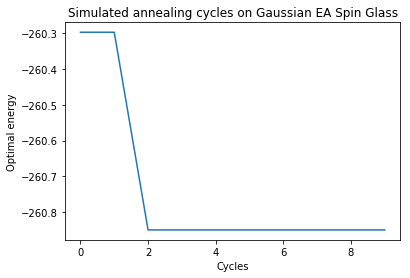

In [32]:
plt.figure()
plt.plot(FinalEnergies)
plt.title('Simulated annealing cycles on Gaussian EA Spin Glass')
plt.xlabel('Cycles')
plt.ylabel('Optimal energy')
#plt.savefig('FinalEnergies.png')
#np.save('Evolution.npy', FinalEnergies)
print(FinalEnergies)

And we can also plot the state which corresponds to the minimum energy. There can be more than one! For example, if the couplings would have been bimodal ($\pm$1), the system is known to have a big degeneracy. For Gaussian couplings, there can also be degeneracy.


THE MINIMUM ENERGY FOUND IS:  -260.8489363922519


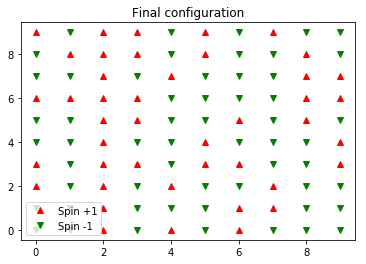

In [33]:
PlotState('Final configuration', BestState, SpinX, SpinY)
GroundState = min(FinalEnergies)
print('\nTHE MINIMUM ENERGY FOUND IS: ', GroundState)

We could also check how the energy is lowered at a particular cycle. That is why we saved energy evolution (if we want the program to be efficient, saving all these data is not a good idea but is nice to understand what is going on).

Text(0,0.5,'Energy')

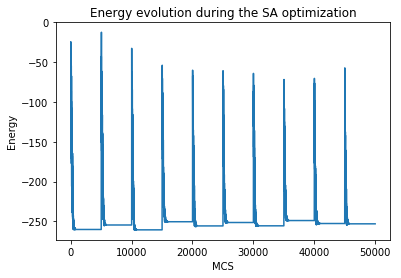

In [34]:
plt.figure()
plt.plot(EnergyEvolution)
plt.title('Energy evolution during the SA optimization')
plt.xlabel('MCS')
plt.ylabel('Energy')

For a difficult spin glass problem, doing temperature cycles enhances our possibilities of finding the ground state. Nevertheless, there are better algorithms that do this in a more clever way, such as Parallel Tempering or Population annealing.

This algorithm is just a simple application of Simulated Annealing, but more efficiency needs to be achieved if you want to work with bigger lattices or 3D problems (actually, over 16x16 lattices in 2D we start to need long computation times). 

This process can be easily parallelized because of the fact that we are considering only nearest neighbours and can be implemented for example in an FPGA. There are also implementations of the idea behind this algorithm on quantum systems in the so called Quantum Annealing.